<a href="https://colab.research.google.com/github/dagmaros27/NLP/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = "/content/drive/My Drive/dev_phase.zip"
!mkdir -p /content/dev_phase
!unzip "$zip_path" -d /content/dev_phase


Archive:  /content/drive/My Drive/dev_phase.zip
   creating: /content/dev_phase/subtask1/
   creating: /content/dev_phase/subtask1/dev/
  inflating: /content/dev_phase/subtask1/dev/nep.csv  
  inflating: /content/dev_phase/subtask1/dev/ita.csv  
  inflating: /content/dev_phase/subtask1/dev/pol.csv  
  inflating: /content/dev_phase/subtask1/dev/rus.csv  
  inflating: /content/dev_phase/subtask1/dev/tel.csv  
  inflating: /content/dev_phase/subtask1/dev/hin.csv  
  inflating: /content/dev_phase/subtask1/dev/hau.csv  
  inflating: /content/dev_phase/subtask1/dev/pan.csv  
  inflating: /content/dev_phase/subtask1/dev/ori.csv  
  inflating: /content/dev_phase/subtask1/dev/spa.csv  
  inflating: /content/dev_phase/subtask1/dev/deu.csv  
  inflating: /content/dev_phase/subtask1/dev/fas.csv  
  inflating: /content/dev_phase/subtask1/dev/arb.csv  
  inflating: /content/dev_phase/subtask1/dev/ben.csv  
  inflating: /content/dev_phase/subtask1/dev/amh.csv  
  inflating: /content/dev_phase/subtask

# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from textblob import TextBlob


In [ ]:
DATASET_PATH = "./dev_phase/subtask1/train/eng.csv"
df = pd.read_csv(DATASET_PATH)

# -----------------------------------------------
# data = {
#     'id': ['1', '2', '3', '4', '5'],
#     'text': [
#         '"Conservative values" okay junior. Its an oxymoron, and hes just a moron.',
#         'Nazi is a subcategory of fascist',
#         'Theyre not interested in the rights given to 43,000 asylum seekers but with the removal of rights from 70 million citizens',
#         'The weather is quite nice today for a walk.',
#         'You are undeniably the worst president in history, absolutely shameful!'
#     ],
#     'polarization': [1, 0, 1, 0, 1]
# }
# df = pd.DataFrame(data)
# -----------------------------------------------

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (3222, 3)


,id,text,polarization
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0


## Class Distribution

/tmp/ipython-input-166257932.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='polarization', data=df, palette='viridis')


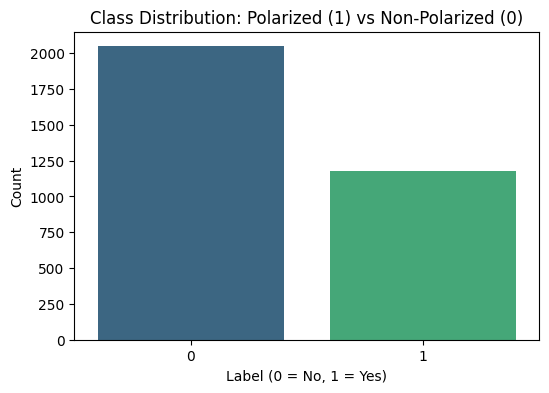

polarization
0    63.531968
1    36.468032
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='polarization', data=df, palette='viridis')
plt.title('Class Distribution: Polarized (1) vs Non-Polarized (0)')
plt.xlabel('Label (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


print(df['polarization'].value_counts(normalize=True) * 100)

## Distribution of word count

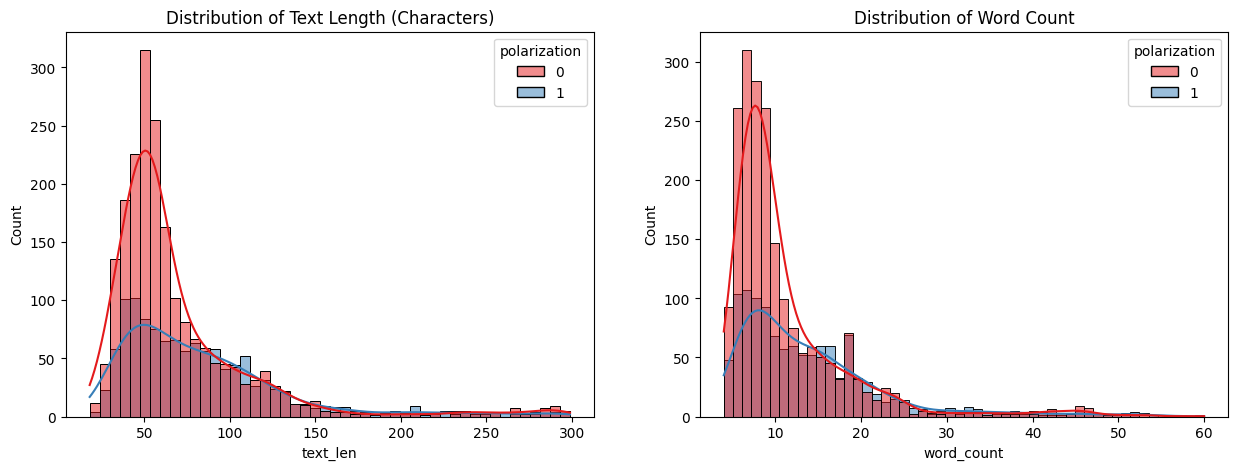

In [ ]:
# Create features for analysis
df['text_len'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character Length
sns.histplot(df, x='text_len', hue='polarization', kde=True, ax=axes[0], palette='Set1')
axes[0].set_title('Distribution of Text Length (Characters)')

# Word Count
sns.histplot(df, x='word_count', hue='polarization', kde=True, ax=axes[1], palette='Set1')
axes[1].set_title('Distribution of Word Count')

plt.show()

## Sentiment Analysis

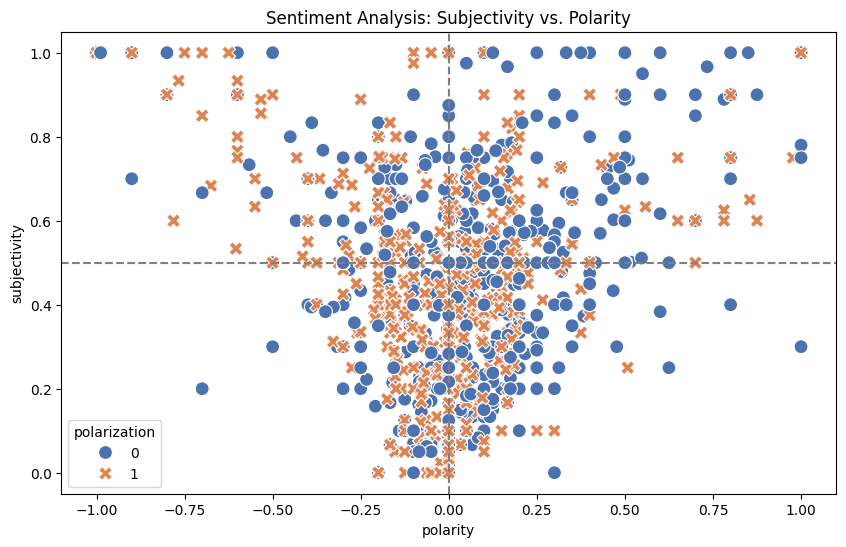

In [ ]:
# Function to get subjectivity (0 = Objective/Fact, 1 = Subjective/Opinion)
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Function to get polarity (-1 = Negative, 1 = Positive)
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df['subjectivity'] = df['text'].apply(get_subjectivity)
df['polarity'] = df['text'].apply(get_polarity)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='polarity', y='subjectivity', hue='polarization', style='polarization', s=100, palette='deep')
plt.title('Sentiment Analysis: Subjectivity vs. Polarity')
plt.axvline(0, color='grey', linestyle='--') # Neutral polarity line
plt.axhline(0.5, color='grey', linestyle='--') # Subjectivity threshold
plt.show()

## Common Words

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
from collections import Counter
from nltk.corpus import stopwords
stop_words = stopwords.words('english') # (Noise words to ignore)


# Helper function to clean text and get top words
def get_clean_top_words(text_series, top_k=10):
    all_words = []

    for text in text_series:
        text = text.lower()

        # Remove punctuation using Regex
        # This keeps only letters (a-z) and numbers
        text = re.sub(r'[^\w\s]', '', text)

        # Split into words
        words = text.split()

        # Add to list ONLY if not a stopword
        for word in words:
            if word not in stop_words and len(word) > 2: # skip 1-2 letter bugs
                all_words.append(word)

    return Counter(all_words).most_common(top_k)

polarized_text = df[df['polarization'] == 1]['text']
non_polarized_text = df[df['polarization'] == 0]['text']

top_pol_words = get_clean_top_words(polarized_text)
top_non_pol_words = get_clean_top_words(non_polarized_text)

print("--- TOP WORDS IN POLARIZED TEXT ---")
for word, count in top_pol_words:
    print(f"{word}: {count}")

print("\n--- TOP WORDS IN NON-POLARIZED TEXT ---")
for word, count in top_non_pol_words:
    print(f"{word}: {count}")

--- TOP WORDS IN POLARIZED TEXT ---
state: 91
election: 89
trump: 83
like: 61
states: 56
people: 55
immigration: 44
israel: 42
apartheid: 40
ukraine: 39

--- TOP WORDS IN NON-POLARIZED TEXT ---
gaza: 126
gop: 125
trump: 125
ukraine: 121
donald: 92
military: 82
biden: 80
war: 78
harris: 78
aid: 77


## Absolutist word count

In [ ]:
absolutist_words = {
    "always", "never", "completely", "totally", "absolutely", "entirely",
    "forever", "nothing", "everyone", "no one", "must", "should", "all",
    "none", "perfect", "terrible", "worst", "best", "disaster", "awful",
    "ruined", "failure", "hopeless", "everybody", "everything", "impossible",
    "only", "entire", "constant", "definitely"
}


def count_absolutist(text):
    count = 0
    for word in text.lower().split():
        if word in absolutist_words:
            count += 1
    return count

df['absolutist_count'] = df['text'].apply(count_absolutist)

# Check average absolutist words per class
print("\nAverage Absolutist Words per Class:")
print(df.groupby('polarization')['absolutist_count'].mean())


Average Absolutist Words per Class:
polarization
0    0.089888
1    0.184681
Name: absolutist_count, dtype: float64
